In [28]:
reset -fs

In [63]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from matplotlib import pyplot as plt
import spacy
import re

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [32]:
df = pd.read_csv('corpus_clean.csv')
df

,info,date,body,positions,author,tag,storm,datetime,mph,category,lat,lon,geometry
0,ZCZC MIATCDAT3 ALL TTAA00 KNHC DDHHMM Tropica...,500 PM -0400 Sun Oct 07 2018,late-arriving ascat data from shortly after 12...,INIT 07/2100Z 35.9N 49.9W 50 KT 60 MPH 12H 08...,zelinsky,al132018_discus_046,al132018,2018-10-07 21:00:00+00:00,60,TS,35.9,49.9,POINT (49.9 35.9)
1,ZCZC MIATCDAT1 ALL TTAA00 KNHC DDHHMM Hurrica...,500 PM -0400 Mon Sep 10 2018,"unfortunately, the models were right. florence...",INIT 10/2100Z 25.4N 61.1W 120 KT 140 MPH 12H 1...,blake,al062018_discus_046,al062018,2018-09-10 21:00:00+00:00,140,4,25.4,61.1,POINT (61.1 25.4)
2,ZCZC MIATCDAT2 ALL TTAA00 KNHC DDHHMM Tropica...,400 PM -0500 Tue Aug 08 2017,visible satellite images and surface synoptic ...,INIT 08/2100Z 20.2N 90.3W 35 KT 40 MPH 12H 09...,pasch,al072017_discus_009,al072017,2017-08-08 21:00:00+00:00,40,TS,20.2,90.3,POINT (90.3 20.2)
3,ZCZC MIATCDAT2 ALL TTAA00 KNHC DDHHMM Hurrica...,1100 AM -0400 Thu Sep 07 2017,jose is developing an eye. convection remains...,INIT 07/1500Z 14.9N 50.6W 80 KT 90 MPH 12H 08...,zelinsky,al122017_discus_009,al122017,2017-09-07 15:00:00+00:00,90,1,14.9,50.6,POINT (50.6 14.9)
4,ZCZC MIATCDAT1 ALL TTAA00 KNHC DDHHMM Hurric...,400 PM -0500 Fri Oct 09 2020,reports from an air force reserve hurricane hu...,INIT 09/2100Z 29.3N 93.2W 90 KT 105 MPH 12H 1...,beven,al262020_discus_021,al262020,2020-10-09 21:00:00+00:00,105,2,29.3,93.2,POINT (93.2 29.3)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,ZCZC MIATCDAT2 ALL TTAA00 KNHC DDHHMM TROPICA...,1100 AM -0400 SAT OCT 11 2014,tropical storm fay made the transition to a tr...,INIT 11/1500Z 27.9N 65.3W 60 KT 70 MPH 12H 12...,stewart,al072014_discus_006,al072014,2014-10-11 15:00:00+00:00,70,TS,27.9,65.3,POINT (65.3 27.9)
7614,ZCZC MIATCDEP1 ALL TTAA00 KNHC DDHHMM TROPICA...,800 AM -0700 WED JUL 15 2015,satellite images indicate that the cloud patte...,INIT 15/1500Z 19.0N 132.9W 40 KT 45 MPH 12H 1...,avila,ep062015_discus_013,ep062015,2015-07-15 15:00:00+00:00,45,TS,19.0,132.9,POINT (132.9 19)
7615,ZCZC MIATCDEP3 ALL TTAA00 KNHC DDHHMM HURRICA...,200 PM -0700 SAT AUG 29 2015,recent microwave imagery continued to show jim...,INIT 29/2100Z 12.8N 126.4W 120 KT 140 MPH 12H ...,berg,ep132015_discus_013,ep132015,2015-08-29 21:00:00+00:00,140,4,12.8,126.4,POINT (126.4 12.8)
7616,ZCZC MIATCDAT2 ALL TTAA00 KNHC DDHHMM Tropic...,500 AM -0400 Mon Sep 07 2020,tropical depression seventeen is a large tropi...,INIT 07/0900Z 17.3N 42.1W 30 KT 35 MPH 12H 07...,latto,al172020_discus_002,al172020,2020-09-07 09:00:00+00:00,35,TD,17.3,42.1,POINT (42.1 17.3)


In [33]:
docs = df['body']

# Custom Stopwords
Since the corpus is so specific, a lot of terms get re-used that create moise in the models (like storm names, which are on a four-year cycle)

In [34]:
# create domain-specific stopword list
my_words = set(['previous','model','consensus','couple','day','tafb','sab','wisconsin','newfoundland',
                'nova','scotia','canadian','lawrence','new','canada','bermuda','carolina','united','states',
                'california','baja','sur','48','24','72','36','kt','wmo','forecast','hurricane','depression',
                'ana','bill','claudette','danny','elsa','fred','grace','henri','ida','julian','kate','larry',
                'mindy','nicholas','odette','peter','rose','sam','teresa','victor','wanda','alex','bonnie',
                'colin','danielle','earl','fiona','gaston','hermine','ian','julia','karl','lisa','martin',
                'nicole','owen','paula','richard','shary','tobias','virginie','walter','arlene','bret','cindy',
                'don','emily','franklin','gert','harold','idalia','jose','katia','lee','margot','nigel',
                'ophelia','philippe','rina','sean','tammy','vince','whitney','alberto','beryl','chris','debby',
                'ernesto','francine','gordon','helene','isaac','joyce','kirk','leslie','milton','nadine',
                'oscar','patty','rafael','sara','tony','valerie','william','andrea','barry','chantal','dexter',
                'erin','fernand','gabrielle','humberto','imelda','jerry','karen','lorenzo','melissa','nestor',
                'olga','pablo','rebekah','sebastien','tanya','van','wendy','arthur','bertha','cristobal','dolly',
                'edouard','fay','gonzalo','hanna','isaias','josephine','kyle','leah','marco','nana','omar',
                'paulette','rene','sally','teddy','vicky','wilfred','andres','blanca','carlos','dolores',
                'enrique','felicia','guillermo','hilda','ignacio','jimena','kevin','linda','marty','nora',
                'olaf','pamela','rick','sandra','terry','vivian','waldo','xina','york','zelda','agatha','blas',
                'celia','darby','estelle','frank','georgette','howard','ivette','javier','kay','lester',
                'madeline','newton','orlene','paine','roslyn','seymour','tina','virgil','winifred','xavier',
                'yolanda','zeke','adrian','beatriz','calvin','dora','eugene','fernanda','greg','hilary',
                'irwin','jova','kenneth','lidia','max','norma','otis','pilar','ramon','selma','todd','veronica',
                'wiley','xina','york','zelda','aletta','bud','carlotta','daniel','emilia','fabio','gilma',
                'hector','ileana','john','kristy','lane','miriam','norman','olivia','paul','rosa','sergio','tara',
                'vicente','willa','xavier','yolanda','zeke','alvin','barbara','cosme','dalila','erick',
                'flossie','gil','henriette','ivo','juliette','kiko','lorena','mario','narda','octave','priscilla',
                'raymond','sonia','tico','velma','wallis','xina','york','zelda','amanda','boris','cristina',
                'douglas','elida','fausto','genevieve','hernan','iselle','julio','karina','lowell','marie',
                'norbert','odalys','polo','rachel','simon','trudy','vance','winnie','xavier','yolanda','zeke',
                'sandy','ingrid','erika','joaquin','matthew','otto','harvey','irma','maria','nate','florence',
                'michael','dorian','laura','manuel','eta','iota','epsilon','theta','delta','odile','florida',
                'panhandle','keys','georgia','louisiana','mississippi','tennessee','alabama','arkansas','ohio',
                'appalachians','maine','america','hawaiian','hawaii','mexico','grand','cayman','virgin','islands',
                'puerto','rico','yucatan','campeche','bay','mexican','caribbean','peninsula','hispaniola','lesser',
                'antilles','dominican','republic','nicaragua','honduras','bahamas','bahama','cuba','jamaica',
                'isle'])

In [35]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

# SpaCy Preprocessing

In [36]:
nlp = spacy.load('en_core_web_sm')

In [37]:
spacy_docs = list(nlp.pipe(df.body))
df['spacy_doc'] = spacy_docs

In [38]:
spacy_docs_clean = [[w.lemma_.lower() for w in spacy_doc if (not w.is_stop and not w.is_punct and not w.like_num) \
               or (w.lemma_=='not')] for spacy_doc in spacy_docs]
df['spacy_docs_clean'] = spacy_docs_clean
df['spacy_docs_clean']

0       [late, arrive, ascat, datum, shortly, utc, ind...
1       [unfortunately, model, right, florence, rapidl...
2       [visible, satellite, image, surface, synoptic,...
3       [jose, develop, eye,  , convection, remain, sy...
4       [report, air, force, reserve, hurricane, hunte...
                              ...                        
7613    [tropical, storm, fay, transition, tropical, c...
7614    [satellite, image, indicate, cloud, pattern, l...
7615    [recent, microwave, imagery, continue, jimena,...
7616    [tropical, depression, large, tropical, cyclon...
7617    [circulation, bertha, remain, compact, define,...
Name: spacy_docs_clean, Length: 7618, dtype: object

In [39]:
spacy_list_clean = [' '.join(doc) for doc in spacy_docs_clean]

# Vectorize

In [40]:
# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [41]:
# CountVectorizer with spacy - again because of the cyclically repetitive corpus, I got the best results with max_df = 0.3.
# Setting max_features helped reduce noise based on scientific abbreviations and tags.

cv = CountVectorizer(strip_accents = 'unicode',
                                stop_words = set(my_stop_words),
                                max_features=2000,
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                ngram_range=(1,3),
                                max_df = 0.3, 
                                min_df = 25)
spacy_dtm_cv = cv.fit_transform(spacy_list_clean)
print(spacy_dtm_cv.shape)
spacy_dtm_cv

(7618, 2000)


<7618x2000 sparse matrix of type '<class 'numpy.int64'>'
	with 781895 stored elements in Compressed Sparse Row format>

In [42]:
# TfidfVectorizer with spacy - this was noisier, I went with CV
with warnings.catch_warnings(record=True):
    tfidf = TfidfVectorizer(**cv.get_params())
    spacy_dtm_tfidf = tfidf.fit_transform(spacy_list_clean)
    print(spacy_dtm_tfidf.shape)

(7618, 2000)


In [43]:
spacy_dtm_cv_df = pd.DataFrame(spacy_dtm_cv.toarray(), columns=cv.get_feature_names())
spacy_dtm_cv_df.head()

,able,absorb,absorb large,accelerate,accelerate northeastward,acceleration,accordingly,account,activity,addition,...,wind speed set,wind storm,wind storm surge,wind vector,wobble,wrap,yesterday,yield,yield initial,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0


# LDA Topic Modeling

In [44]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [76]:
lda_spacy_3 = LatentDirichletAllocation(n_components=3, random_state=0)
topics = lda_spacy_3.fit(spacy_dtm_cv)
lda_spacy_vis_3 = pyLDAvis.sklearn.prepare(lda_spacy_3, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis_3

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.077744  0.165808       1        1  29.678656
1      0.038663 -0.110905       2        1  19.561164
2     -0.116407 -0.054903       3        1  50.760180, topic_info=               Term         Freq        Total Category  logprob  loglift
595        flooding  2354.000000  2354.000000  Default  30.0000  30.0000
1172  northeastward  2672.000000  2672.000000  Default  29.0000  29.0000
1359       rainfall  2158.000000  2158.000000  Default  28.0000  28.0000
547   extratropical  1610.000000  1610.000000  Default  27.0000  27.0000
703           heavy  2017.000000  2017.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1267        pattern  1569.710798  2573.027307   Topic3  -5.6456   0.1839
1700    subtropical  1499.086083  2383.928470   Topic3  -5.6917   0.2142
1436         result  1536.737475  2665.232063   Topic3  -5.6669   0.1274
1703        suggest  1494.580628  2409.975074   Topic3  -5.6947   0.2003
660            good  1470.490885  2378.811598   Topic3  -5.7109   0.1971

[239 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.015175        absorb
1         2  0.983028        absorb
2         2  0.996424  absorb large
3         1  0.125136    accelerate
3         2  0.766678    accelerate
...     ...       ...           ...
1987      2  0.097012    wind shear
1987      3  0.770190    wind shear
1999      1  0.103098          zone
1999      2  0.892445          zone
1999      3  0.006444          zone

[460 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [82]:
lda_spacy_5 = LatentDirichletAllocation(n_components=5, random_state=0)
topics = lda_spacy_5.fit(spacy_dtm_cv)
lda_spacy_vis_5 = pyLDAvis.sklearn.prepare(lda_spacy_5, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis_5

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.224048 -0.030001       1        1  12.247155
1     -0.008568  0.155959       2        1  13.364266
2     -0.153139 -0.045996       3        1  34.217645
3     -0.145610  0.068580       4        1  21.355331
4      0.083268 -0.148543       5        1  18.815602, topic_info=               Term         Freq        Total Category  logprob  loglift
595        flooding  2329.000000  2329.000000  Default  30.0000  30.0000
547   extratropical  1604.000000  1604.000000  Default  29.0000  29.0000
1359       rainfall  2153.000000  2153.000000  Default  28.0000  28.0000
703           heavy  2006.000000  2006.000000  Default  27.0000  27.0000
878        landfall  1573.000000  1573.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1748       threaten   684.027625  1476.371386   Topic5  -5.4839   0.9011
127           begin   722.930571  2770.237141   Topic5  -5.4286   0.3271
1769          today   714.180413  2546.602310   Topic5  -5.4407   0.3991
951   life threaten   676.926980  1466.347649   Topic5  -5.4943   0.8975
901           later   681.378917  2133.414838   Topic5  -5.4877   0.5291

[384 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.057566        absorb
1         2  0.873654        absorb
1         4  0.067725        absorb
2         1  0.010199  absorb large
2         2  0.968908  absorb large
...     ...       ...           ...
1999      1  0.071113          zone
1999      2  0.827498          zone
1999      3  0.003232          zone
1999      4  0.054951          zone
1999      5  0.045254          zone

[1100 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

In [78]:
lda_spacy_8 = LatentDirichletAllocation(n_components=8, random_state=0)
topics = lda_spacy_8.fit(spacy_dtm_cv)
lda_spacy_vis_8 = pyLDAvis.sklearn.prepare(lda_spacy_8, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis_8

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.087868  0.241929       1        1   7.249345
1     -0.101176  0.098544       2        1  10.094739
2      0.015567 -0.126713       3        1  24.135898
3     -0.020321 -0.200292       4        1  14.174659
4      0.160414  0.058830       5        1   9.467201
5     -0.117084 -0.097631       6        1  17.301891
6     -0.292904  0.001227       7        1   5.285389
7      0.267636  0.024105       8        1  12.290879, topic_info=               Term         Freq        Total Category  logprob  loglift
1418    remnant low  2996.000000  2996.000000  Default  30.0000  30.0000
547   extratropical  1626.000000  1626.000000  Default  29.0000  29.0000
595        flooding  2363.000000  2363.000000  Default  28.0000  28.0000
405       dissipate  1929.000000  1929.000000  Default  27.0000  27.0000
858          island  2207.000000  2207.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
1350          radar   516.573830   857.379085   Topic8  -5.3388   1.5897
1328       pressure   576.683614  2014.231001   Topic8  -5.2287   0.8456
1961        western   584.268431  2630.930856   Topic8  -5.2157   0.5916
1047        message   551.102242  1431.522143   Topic8  -5.2741   1.1417
870     key message   550.288975  1429.507027   Topic8  -5.2756   1.1417

[529 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.023392        absorb
1         2  0.848796        absorb
1         4  0.025063        absorb
1         7  0.103593        absorb
2         2  0.971429  absorb large
...     ...       ...           ...
1987      4  0.563264    wind shear
1987      5  0.072887    wind shear
1987      6  0.097183    wind shear
1987      7  0.050575    wind shear
1987      8  0.026775    wind shear

[2006 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

In [81]:
lda_spacy_10 = LatentDirichletAllocation(n_components=10, random_state=0)
topics = lda_spacy_10.fit(spacy_dtm_cv)
lda_spacy_vis_10 = pyLDAvis.sklearn.prepare(lda_spacy_10, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis_10

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.272958 -0.092021       1        1   6.642260
1     -0.113900 -0.101320       2        1   7.457753
2     -0.158238  0.013325       3        1  19.257204
3     -0.052280  0.055962       4        1  11.287547
4      0.092175 -0.182753       5        1   8.384018
5     -0.085527  0.169986       6        1  12.449379
6      0.064394  0.289446       7        1   5.332039
7      0.090906 -0.278856       8        1  10.319135
8     -0.267242  0.045990       9        1   9.896371
9      0.156754  0.080240      10        1   8.974295, topic_info=               Term         Freq        Total Category  logprob  loglift
1418    remnant low  2963.000000  2963.000000  Default  30.0000  30.0000
595        flooding  2368.000000  2368.000000  Default  29.0000  29.0000
547   extratropical  1621.000000  1621.000000  Default  28.0000  28.0000
1359       rainfall  2165.000000  2165.000000  Default  27.0000  27.0000
703           heavy  2023.000000  2023.000000  Default  26.0000  26.0000
...             ...          ...          ...      ...      ...      ...
76         approach   429.793088  1726.311340  Topic10  -5.2082   1.0204
447      east coast   357.583819   749.310078  Topic10  -5.3922   1.6710
614           force   400.645820  2877.042722  Topic10  -5.2785   0.4394
1957       westerly   378.733756  1637.011566  Topic10  -5.3347   0.9470
244       condition   389.089921  2886.018610  Topic10  -5.3077   0.4070

[651 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1         1  0.021767      absorb
1         2  0.194227      absorb
1         4  0.095439      absorb
1         7  0.100462      absorb
1        10  0.587703      absorb
...     ...       ...         ...
1989      6  0.174046  wind speed
1989      7  0.047400  wind speed
1989      8  0.082949  wind speed
1989      9  0.002222  wind speed
1989     10  0.117758  wind speed

[2983 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [86]:
lda_spacy_12 = LatentDirichletAllocation(n_components=12, random_state=0)
topics = lda_spacy_12.fit(spacy_dtm_cv)
lda_spacy_vis_12 = pyLDAvis.sklearn.prepare(lda_spacy_12, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis_12

/Users/noether/miniforge3/envs/eclipse/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/noether/miniforge3/envs/eclipse/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/noether/miniforge3/envs/eclipse/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/Users/noether/miniforge3/envs/eclipse/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour o

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.256890  0.028089       1        1   6.159300
1     -0.130477 -0.139504       2        1   7.096249
2     -0.154734 -0.002775       3        1  15.063313
3     -0.037440  0.051148       4        1  11.423712
4      0.058167 -0.211664       5        1   7.375107
5     -0.109114  0.152372       6        1  11.657337
6      0.032262  0.321794       7        1   4.286644
7      0.175428 -0.246725       8        1   7.531411
8     -0.236023 -0.061315       9        1   7.777257
9      0.137577  0.124433      10        1   7.404481
10     0.238371 -0.139602      11        1   5.778397
11    -0.230908  0.123750      12        1   8.446792, topic_info=             Term         Freq        Total Category  logprob  loglift
1418  remnant low  2942.000000  2942.000000  Default  30.0000  30.0000
595      flooding  2353.000000  2353.000000  Default  29.0000  29.0000
1721        surge  1726.000000  1726.000000  Default  28.0000  28.0000
1660  storm surge  1656.000000  1656.000000  Default  27.0000  27.0000
1359     rainfall  2153.000000  2153.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1267      pattern   386.023596  2585.767370  Topic12  -5.2551   0.5695
133         blend   354.073014  1920.130257  Topic12  -5.3415   0.7807
992        locate   351.869640  2157.312961  Topic12  -5.3477   0.6580
1213        occur   346.928666  2291.278433  Topic12  -5.3618   0.5836
1263         past   343.310601  2229.500158  Topic12  -5.3723   0.6005

[726 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3         1  0.201218      accelerate
3         2  0.040069      accelerate
3         3  0.021777      accelerate
3         4  0.128919      accelerate
3         5  0.005226      accelerate
...     ...       ...             ...
1990      3  0.691819  wind speed set
1990      6  0.005913  wind speed set
1990      7  0.100521  wind speed set
1990      8  0.059130  wind speed set
1990     10  0.141912  wind speed set

[3785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

# Best model by inspection: 4 topics
I liked this one because the topics were well-separated, and topic terms were mappable to:
* Strong, dangerous landfalling storms (topic 1)
* Weaker landfalling and land-grazing storms (topic 2)
* Strong or stable storms with no landfall or land interaction (yet) (topic 3)
* Weakening or struggling storms with no landfall or land interaction (yet) (topic 4)

In [77]:
lda_spacy_4 = LatentDirichletAllocation(n_components=4, random_state=0)
topics = lda_spacy_4.fit(spacy_dtm_cv)
lda_spacy_vis_4 = pyLDAvis.sklearn.prepare(lda_spacy_4, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis_4

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.194087  0.047149       1        1  24.642856
1      0.039173 -0.105111       2        1  12.199693
2     -0.140752 -0.039261       3        1  37.864615
3     -0.092508  0.097223       4        1  25.292836, topic_info=                 Term         Freq        Total Category  logprob  loglift
595          flooding  2351.000000  2351.000000  Default  30.0000  30.0000
1721            surge  1700.000000  1700.000000  Default  29.0000  29.0000
1660      storm surge  1631.000000  1631.000000  Default  28.0000  28.0000
1359         rainfall  2161.000000  2161.000000  Default  27.0000  27.0000
703             heavy  2023.000000  2023.000000  Default  26.0000  26.0000
...               ...          ...          ...      ...      ...      ...
1095  motion estimate   800.167788  2022.627258   Topic4  -5.6229   0.4473
358          decrease   860.207270  2705.236622   Topic4  -5.5505   0.2289
1213            occur   803.369770  2288.714248   Topic4  -5.6189   0.3277
1180        northward   812.458456  2915.859337   Topic4  -5.6076   0.0968
608            follow   804.008191  2622.984408   Topic4  -5.6181   0.1922

[331 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
1         1  0.091797        absorb
1         2  0.037399        absorb
1         4  0.870376        absorb
2         1  0.041033  absorb large
2         2  0.005129  absorb large
...     ...       ...           ...
1987      3  0.387251    wind shear
1987      4  0.490979    wind shear
1993      2  0.060139   wind vector
1993      3  0.033411   wind vector
1993      4  0.908767   wind vector

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

In [83]:
# create doc-topic matrix 
lda_output = lda_spacy_4.transform(spacy_dtm_cv)
topicnames = ["topic" + str(i+1) for i in range(lda_spacy_4.n_components)]
docnames = [df['tag']]

# make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames)

# get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = (dominant_topic + 1)
df_document_topic['tag'] = df['tag']
df_document_topic

,topic1,topic2,topic3,topic4,dominant_topic,tag
0,0.00,0.32,0.42,0.26,3,al132018_discus_046
1,0.86,0.02,0.12,0.00,1,al062018_discus_046
2,0.05,0.67,0.28,0.00,2,al072017_discus_009
3,0.00,0.12,0.63,0.25,3,al122017_discus_009
4,0.92,0.00,0.00,0.08,1,al262020_discus_021
...,...,...,...,...,...,...
7613,0.23,0.00,0.00,0.76,4,al072014_discus_006
7614,0.00,0.66,0.33,0.00,2,ep062015_discus_013
7615,0.00,0.00,0.99,0.00,3,ep132015_discus_013
7616,0.00,0.00,0.99,0.00,3,al172020_discus_002


In [84]:
discussion_topics = pd.merge(df, df_document_topic, on='tag', how='outer')
discussion_topics_clean = discussion_topics.drop(['info','date', 'positions', 'spacy_doc','spacy_docs_clean'], axis=1)  
discussion_topics_clean

,body,author,tag,storm,datetime,mph,category,lat,lon,geometry,topic1,topic2,topic3,topic4,dominant_topic
0,late-arriving ascat data from shortly after 12...,zelinsky,al132018_discus_046,al132018,2018-10-07 21:00:00+00:00,60,TS,35.9,49.9,POINT (49.9 35.9),0.00,0.32,0.42,0.26,3
1,"unfortunately, the models were right. florence...",blake,al062018_discus_046,al062018,2018-09-10 21:00:00+00:00,140,4,25.4,61.1,POINT (61.1 25.4),0.86,0.02,0.12,0.00,1
2,visible satellite images and surface synoptic ...,pasch,al072017_discus_009,al072017,2017-08-08 21:00:00+00:00,40,TS,20.2,90.3,POINT (90.3 20.2),0.05,0.67,0.28,0.00,2
3,jose is developing an eye. convection remains...,zelinsky,al122017_discus_009,al122017,2017-09-07 15:00:00+00:00,90,1,14.9,50.6,POINT (50.6 14.9),0.00,0.12,0.63,0.25,3
4,reports from an air force reserve hurricane hu...,beven,al262020_discus_021,al262020,2020-10-09 21:00:00+00:00,105,2,29.3,93.2,POINT (93.2 29.3),0.92,0.00,0.00,0.08,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7613,tropical storm fay made the transition to a tr...,stewart,al072014_discus_006,al072014,2014-10-11 15:00:00+00:00,70,TS,27.9,65.3,POINT (65.3 27.9),0.23,0.00,0.00,0.76,4
7614,satellite images indicate that the cloud patte...,avila,ep062015_discus_013,ep062015,2015-07-15 15:00:00+00:00,45,TS,19.0,132.9,POINT (132.9 19),0.00,0.66,0.33,0.00,2
7615,recent microwave imagery continued to show jim...,berg,ep132015_discus_013,ep132015,2015-08-29 21:00:00+00:00,140,4,12.8,126.4,POINT (126.4 12.8),0.00,0.00,0.99,0.00,3
7616,tropical depression seventeen is a large tropi...,latto,al172020_discus_002,al172020,2020-09-07 09:00:00+00:00,35,TD,17.3,42.1,POINT (42.1 17.3),0.00,0.00,0.99,0.00,3


In [62]:
lda_spacy_vis = pyLDAvis.sklearn.prepare(lda_spacy, spacy_dtm_cv, cv, mds='mmds', sort_topics=False)
lda_spacy_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.256890  0.028089       1        1   6.159300
1     -0.130477 -0.139504       2        1   7.096249
2     -0.154734 -0.002775       3        1  15.063313
3     -0.037440  0.051148       4        1  11.423712
4      0.058167 -0.211664       5        1   7.375107
5     -0.109114  0.152372       6        1  11.657337
6      0.032262  0.321794       7        1   4.286644
7      0.175428 -0.246725       8        1   7.531411
8     -0.236023 -0.061315       9        1   7.777257
9      0.137577  0.124433      10        1   7.404481
10     0.238371 -0.139602      11        1   5.778397
11    -0.230908  0.123750      12        1   8.446792, topic_info=             Term         Freq        Total Category  logprob  loglift
1418  remnant low  2942.000000  2942.000000  Default  30.0000  30.0000
595      flooding  2353.000000  2353.000000  Default  29.0000  29.0000
1721        surge  1726.000000  1726.000000  Default  28.0000  28.0000
1660  storm surge  1656.000000  1656.000000  Default  27.0000  27.0000
1359     rainfall  2153.000000  2153.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
1267      pattern   386.023596  2585.767370  Topic12  -5.2551   0.5695
133         blend   354.073014  1920.130257  Topic12  -5.3415   0.7807
992        locate   351.869640  2157.312961  Topic12  -5.3477   0.6580
1213        occur   346.928666  2291.278433  Topic12  -5.3618   0.5836
1263         past   343.310601  2229.500158  Topic12  -5.3723   0.6005

[726 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3         1  0.201218      accelerate
3         2  0.040069      accelerate
3         3  0.021777      accelerate
3         4  0.128919      accelerate
3         5  0.005226      accelerate
...     ...       ...             ...
1990      3  0.691819  wind speed set
1990      6  0.005913  wind speed set
1990      7  0.100521  wind speed set
1990      8  0.059130  wind speed set
1990     10  0.141912  wind speed set

[3785 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [85]:
#discussion_topics_clean.to_csv('discussion_topics_clean.csv', index=False)

# Coda: Gridsearch
I tried this a few times to see if it could pin down the best model. I found that manual inspection was a bit more informative. Gridsearch really liked 3 topics, but I found 4 to be much more useful.

In [55]:
print("Log Likelihood: ", lda_spacy.score(spacy_dtm_cv))
print("Perplexity: ", lda_spacy.perplexity(spacy_dtm_cv))

# See model parameters
print(lda_spacy.get_params())


Log Likelihood:  -6146237.00573648
Perplexity:  1120.6485032827723
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 0, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -1241812.8435670077
Model Perplexity:  1111.4712290542773


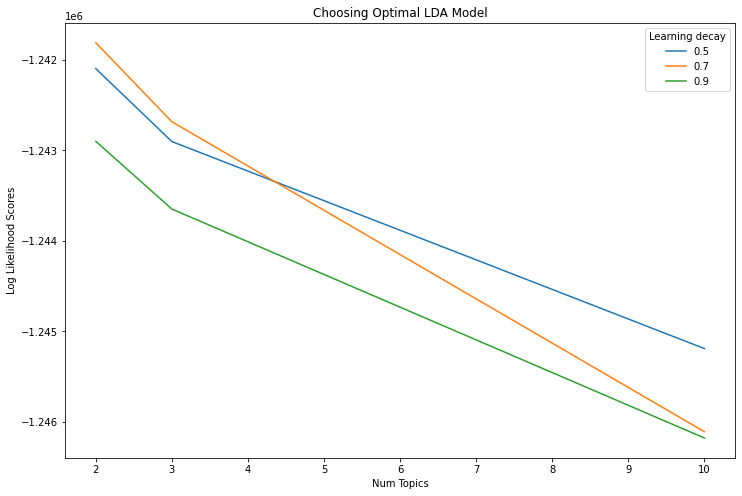

In [64]:
from sklearn.model_selection import GridSearchCV

search_params = {'n_components': [3, 5, 7], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params)
model.fit(spacy_dtm_cv)

best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(spacy_dtm_cv))

# Get log likelihoods
n_topics = [2, 3,10]
log_likelihoods_5 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.5]
log_likelihoods_7 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.7]
log_likelihoods_9 = [round(model.cv_results_['mean_test_score'][index]) for index, gscore in enumerate(model.cv_results_['params']) if gscore['learning_decay']==0.9]

# plot log likelihood graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelihoods_5, label='0.5')
plt.plot(n_topics, log_likelihoods_7, label='0.7')
plt.plot(n_topics, log_likelihoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [65]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,4377
1,1,1760
2,2,1481


In [66]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=3, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 3 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.16  0.21  0.96]
 [ 0.8   0.55 -0.25]]
Perc of Variance Explained: 
 [0.27 0.4 ]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

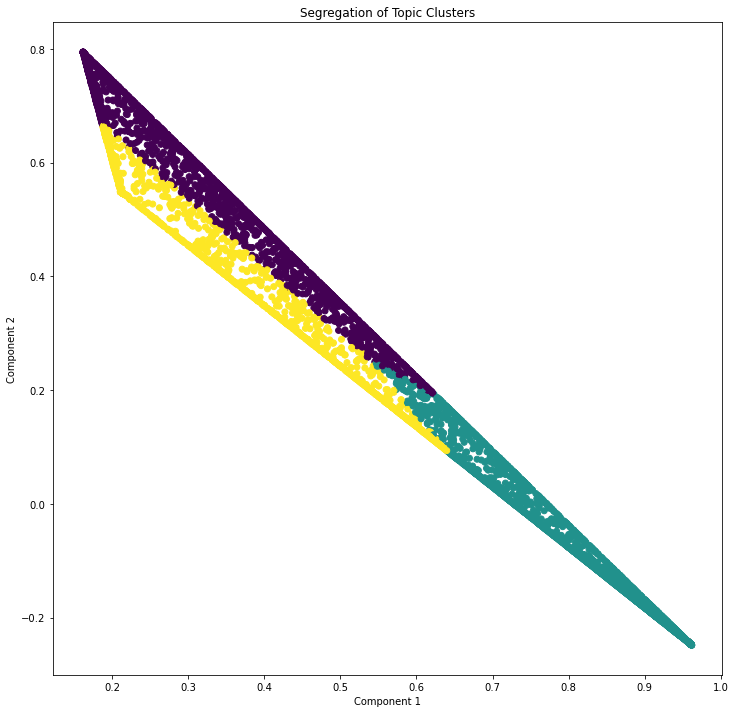

In [67]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )